<a href="https://colab.research.google.com/github/eduardez/Machine-Learning-ESI/blob/master/Dengue_Features_Shift_and_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline

from __future__ import print_function
from __future__ import division

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
import statsmodels.api as sm

# just for the sake of this blog post!
from warnings import filterwarnings
filterwarnings('ignore')

#Autocorrelation
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# load the provided data

test_features_url = 'https://raw.githubusercontent.com/eduardez/Machine-Learning-ESI/master/datasets/dengue_features_test.csv?token=AHJ5UMCDNA6C3YTL3GSARPTAANXLE'
train_features_url = 'https://raw.githubusercontent.com/eduardez/Machine-Learning-ESI/master/datasets/dengue_features_train.csv?token=AHJ5UMBUKUIP3CZEIEI5BNTAANXLK'
train_labels_url = 'https://raw.githubusercontent.com/eduardez/Machine-Learning-ESI/master/datasets/dengue_labels_train.csv?token=AHJ5UMCJ6PTP62F2OPI2CNDAANXLQ'
submission_url = 'https://raw.githubusercontent.com/eduardez/Machine-Learning-ESI/master/datasets/submission_format.csv?token=AHJ5UMAWJGX3NE6BNQ4OQULAANXLU'


train_features_raw = pd.read_csv(train_features_url,index_col=[0,1,2])

train_labels_raw = pd.read_csv( train_labels_url, index_col=[0,1,2])

features_test_raw = pd.read_csv(test_features_url, index_col=[0,1,2])

submission = pd.read_csv(submission_url,index_col=[0,1,2])

In [ ]:
train_features = train_features_raw.copy()
train_labels = train_labels_raw.copy()

### Pre-processing



*The timing of the seasonality of our predictions has a mismatch with the actual results. One potential reason for this is that our features don't look far enough into the past--that is to say, we are asking to predict cases at the same time as we are measuring percipitation. Because dengue is misquito born, and the misquito lifecycle depends on water, we need to take both the life of a misquito and the time between infection and symptoms into account when modeling dengue. This is a critical avenue to explore when improving this model.*

For this reason, we use shift

In [ ]:
#sj_train_features = sj_train_features.shift(periods = 20, fill_value = 0)
#iq_train_features = iq_train_features.shift(periods = 20, fill_value = 0)

def shift(sj_train_features, iq_train_features):
  sj_train_features['reanalysis_precip_amt_kg_per_m2_2w_ago'] = sj_train_features.reanalysis_precip_amt_kg_per_m2.shift(periods = 2, fill_value = 0)
  sj_train_features['precipitation_amt_mm_2w_ago'] = sj_train_features.precipitation_amt_mm.shift(periods = 2, fill_value = 0)
  sj_train_features['station_precip_mm_m2_2w_ago'] = sj_train_features.station_precip_mm.shift(periods = 2, fill_value = 0)
  sj_train_features['reanalysis_specific_humidity_g_per_kg_6w_ago'] = sj_train_features.reanalysis_specific_humidity_g_per_kg.shift(periods = 6, fill_value = 0)
  sj_train_features['station_max_temp_c_6w_ago'] = sj_train_features.station_max_temp_c.shift(periods = 6, fill_value = 0)
  sj_train_features['station_min_temp_c_7w_ago'] = sj_train_features.station_min_temp_c.shift(periods = 7, fill_value = 0)
  sj_train_features['station_avg_temp_c_7w_ago'] = sj_train_features.station_avg_temp_c.shift(periods = 7, fill_value = 0)
  sj_train_features['ndvi_nw_11w_ago'] = sj_train_features.ndvi_nw.shift(periods = 11, fill_value = 0)
  sj_train_features['ndvi_ne_15w_ago'] = sj_train_features.ndvi_ne.shift(periods = 15, fill_value = 0)
  sj_train_features['station_diur_temp_rng_c_18w_ago'] = sj_train_features.station_diur_temp_rng_c.shift(periods = 18, fill_value = 0)

  iq_train_features['precipitation_amt_mm_3w_ago'] = iq_train_features.precipitation_amt_mm.shift(periods = 3, fill_value = 0)
  iq_train_features['station_precip_mm_3w_ago'] = iq_train_features.station_precip_mm.shift(periods = 3, fill_value = 0)
  iq_train_features['station_diur_temp_rng_c_10w_ago'] = iq_train_features.station_diur_temp_rng_c.shift(periods = 10, fill_value = 0)
  iq_train_features['ndvi_sw_11w_ago'] = iq_train_features.ndvi_sw.shift(periods = 11, fill_value = 0)
  iq_train_features['ndvi_ne_11w_ago'] = iq_train_features.ndvi_ne.shift(periods = 11, fill_value = 0)
  iq_train_features['ndvi_nw_11w_ago'] = iq_train_features.ndvi_nw.shift(periods = 11, fill_value = 0)
  iq_train_features['ndvi_se_14w_ago'] = iq_train_features.ndvi_se.shift(periods = 14, fill_value = 0)
  iq_train_features['reanalysis_tdtr_k_15w_ago'] = iq_train_features.reanalysis_tdtr_k.shift(periods = 15, fill_value = 0)
  iq_train_features['reanalysis_air_temp_k_16w_ago'] = iq_train_features.reanalysis_air_temp_k.shift(periods = 16, fill_value = 0)
  iq_train_features['reanalysis_avg_temp_k_16w_ago'] = iq_train_features.reanalysis_avg_temp_k.shift(periods = 16, fill_value = 0)
  iq_train_features['reanalysis_max_air_temp_k_3w_ago'] = iq_train_features.reanalysis_max_air_temp_k.shift(periods = 16, fill_value = 0)

  return sj_train_features, iq_train_features

In [ ]:
def preprocess_data(data_path, labels_path=None):
    # load data and set index to city, year, weekofyear
    df = pd.read_csv(data_path, index_col=[0, 1, 2])

    #we remove those features we high correlation between them
    df.drop('week_start_date', axis=1, inplace=True)
    df.drop("reanalysis_sat_precip_amt_mm", axis = 1, inplace = True)

    # fill missing values
    df.fillna(method='ffill', inplace=True)

    # add labels to dataframe
    if labels_path:
        labels = pd.read_csv(labels_path, index_col=[0, 1, 2])
        df = df.join(labels)
    
    # separate san juan and iquitos
    sj_train = df.loc['sj']
    iq_train = df.loc['iq']

    # add new feautures with shifts

    sj_train, iq_train = shift(sj_train, iq_train)

    # select features we want
    sj_features = ['reanalysis_specific_humidity_g_per_kg_6w_ago',
               'station_min_temp_c_7w_ago',
               'station_avg_temp_c_7w_ago',
               'reanalysis_specific_humidity_g_per_kg',
               'station_max_temp_c_6w_ago',
               'reanalysis_dew_point_temp_k']

    iq_features = ['reanalysis_specific_humidity_g_per_kg',
                  'reanalysis_dew_point_temp_k',
                  'reanalysis_min_air_temp_k',
                  'station_min_temp_c','reanalysis_tdtr_k_15w_ago','ndvi_sw_11w_ago']
    if labels_path:
      sj_features.append('total_cases')
      iq_features.append('total_cases')

    sj_train = sj_train[sj_features]
    iq_train = iq_train[iq_features] 

    return sj_train, iq_train

### Quick Check for Autocorrelation

[Autoregression Models for Time Series Forecasting With Python](https://machinelearningmastery.com/autoregression-models-time-series-forecasting-python/)

*The other important error is that our predictions are relatively consistent--we miss the spikes that are large outbreaks. One reason is that we don't take into account the contagiousness of dengue. A possible way to account for this is to build a model that progressively predicts a new value while taking into account the previous prediction. By training on the dengue outbreaks and then using the predicted number of patients in the week before, we can start to model this time dependence that the current model misses.*

In [ ]:
    sj_train_labels = train_labels.loc['sj']
    iq_train_labels = train_labels.loc['iq']

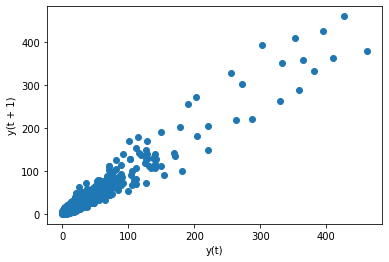

In [ ]:

lag_plot(sj_train_labels, lag=1)
plt.show()


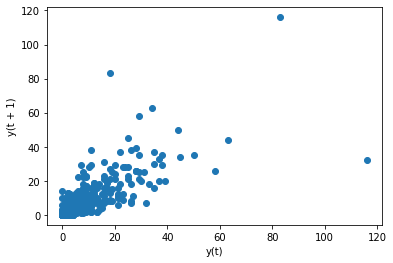

In [ ]:
lag_plot(iq_train_labels, lag=1)
plt.show()

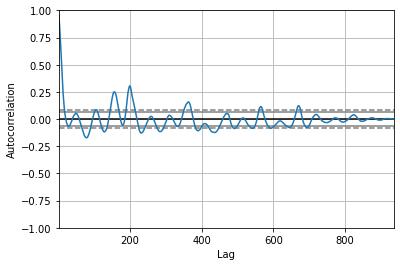

In [ ]:
autocorrelation_plot(sj_train_labels)
plt.show()

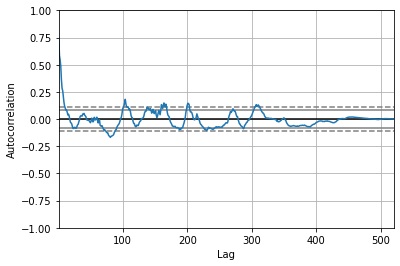

In [ ]:
autocorrelation_plot(iq_train_labels)
plt.show()

In [ ]:
train_labels_date = pd.read_csv(train_labels_url)



train_labels_date['formatted_date'] = train_labels_date.year * 1000 + train_labels_date.weekofyear * 10 + 0

train_labels_date['date'] = pd.to_datetime(train_labels_date['formatted_date'], format='%Y%W%w')
train_labels_date.drop('year', axis=1, inplace=True)
train_labels_date.drop('weekofyear', axis=1, inplace=True)
train_labels_date.drop('formatted_date', axis=1, inplace=True)
train_labels_date.set_index(['city','date'], inplace=True)

print (train_labels_date)

sj_train_labels_date = train_labels_date.loc['sj']
iq_train_labels_date = train_labels_date.loc['iq']

                 total_cases
city date                   
sj   1990-05-06            4
     1990-05-13            5
     1990-05-20            4
     1990-05-27            3
     1990-06-03            6
...                      ...
iq   2010-05-30            5
     2010-06-06            8
     2010-06-13            1
     2010-06-20            1
     2010-06-27            4

[1456 rows x 1 columns]


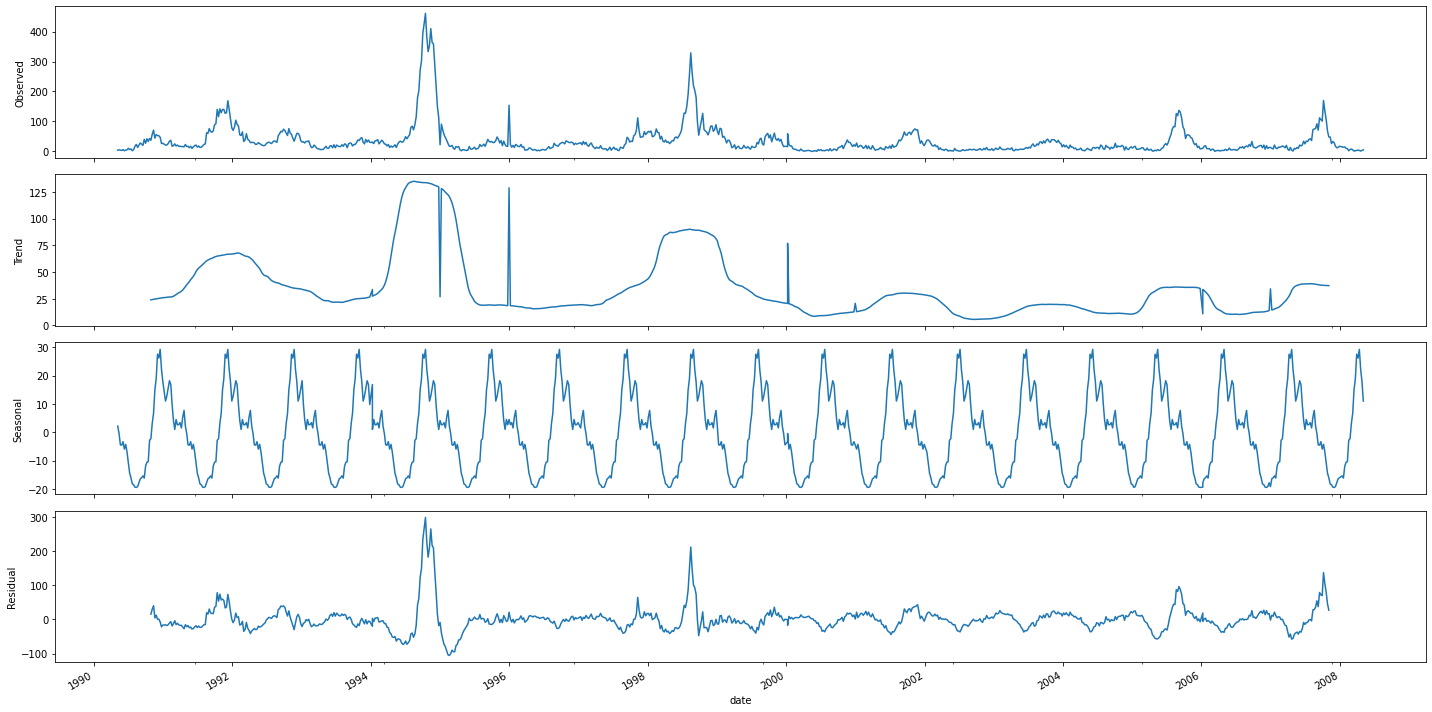

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot

result = seasonal_decompose(sj_train_labels_date, model= 'additive', freq = 50)
pyplot.rcParams["figure.figsize"] = [20,10]
result.plot()
pyplot.show()

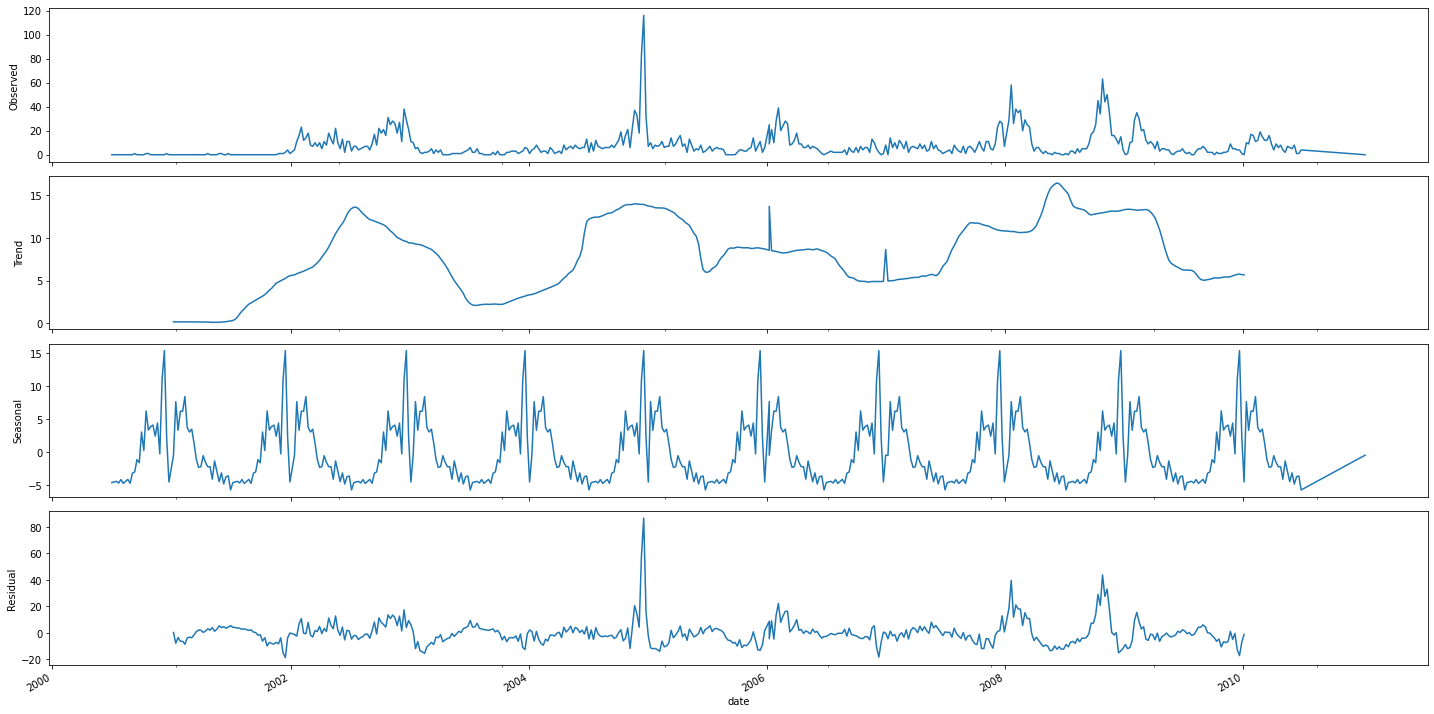

In [ ]:

result = seasonal_decompose(iq_train_labels_date, model= 'additive', freq = 52)
pyplot.rcParams["figure.figsize"] = [20,10]
result.plot()
pyplot.show()

### Study of correlations

In [ ]:
sj_train_features, iq_train_features= preprocess_data(train_features_url, labels_path=train_labels_url)
                                

In [ ]:
# compute the correlations
sj_correlations = sj_train_features.corr()
iq_correlations = iq_train_features.corr()

Text(0.5, 1.0, 'San Juan Variable Correlations')

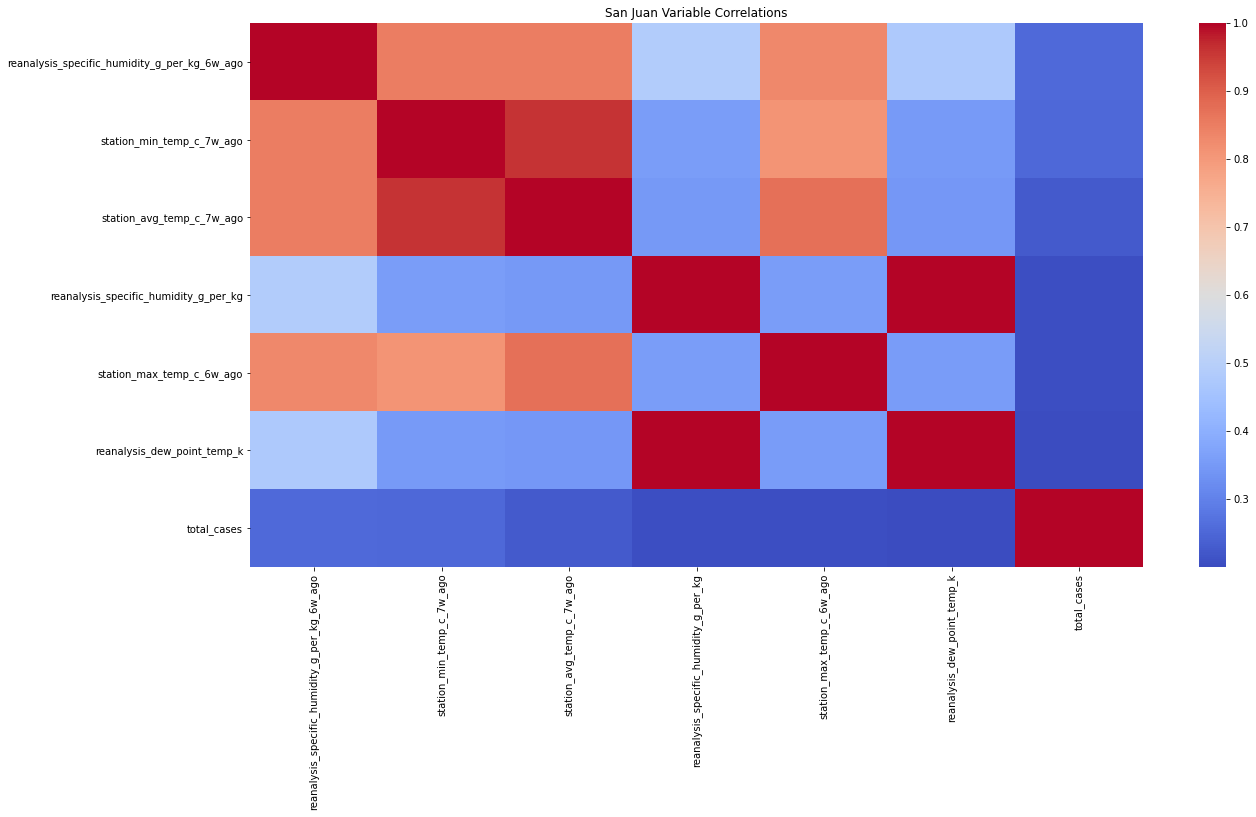

In [ ]:
# plot san juan
sj_corr_heat = sns.heatmap(sj_correlations,cmap='coolwarm',xticklabels=True, yticklabels=True)
plt.title('San Juan Variable Correlations')

In [ ]:
sol = (sj_correlations.where(np.triu(np.ones(sj_correlations.shape), k=1).astype(np.bool))
                 .stack()
                 .sort_values(ascending=False))
for index, value in sol.items():
  if value>0.90:
    print(index, value)

('reanalysis_specific_humidity_g_per_kg', 'reanalysis_dew_point_temp_k') 0.9985311228737223
('station_min_temp_c_7w_ago', 'station_avg_temp_c_7w_ago') 0.9617040170366848


In [ ]:
# San Juan
(sj_correlations
     .total_cases
     .drop('total_cases') # don't compare with myself
     .sort_values(ascending=False))

reanalysis_specific_humidity_g_per_kg_6w_ago    0.254430
station_min_temp_c_7w_ago                       0.251445
station_avg_temp_c_7w_ago                       0.227662
reanalysis_specific_humidity_g_per_kg           0.205338
station_max_temp_c_6w_ago                       0.205054
reanalysis_dew_point_temp_k                     0.201086
Name: total_cases, dtype: float64

Text(0.5, 1.0, 'Iquitos Variable Correlations')

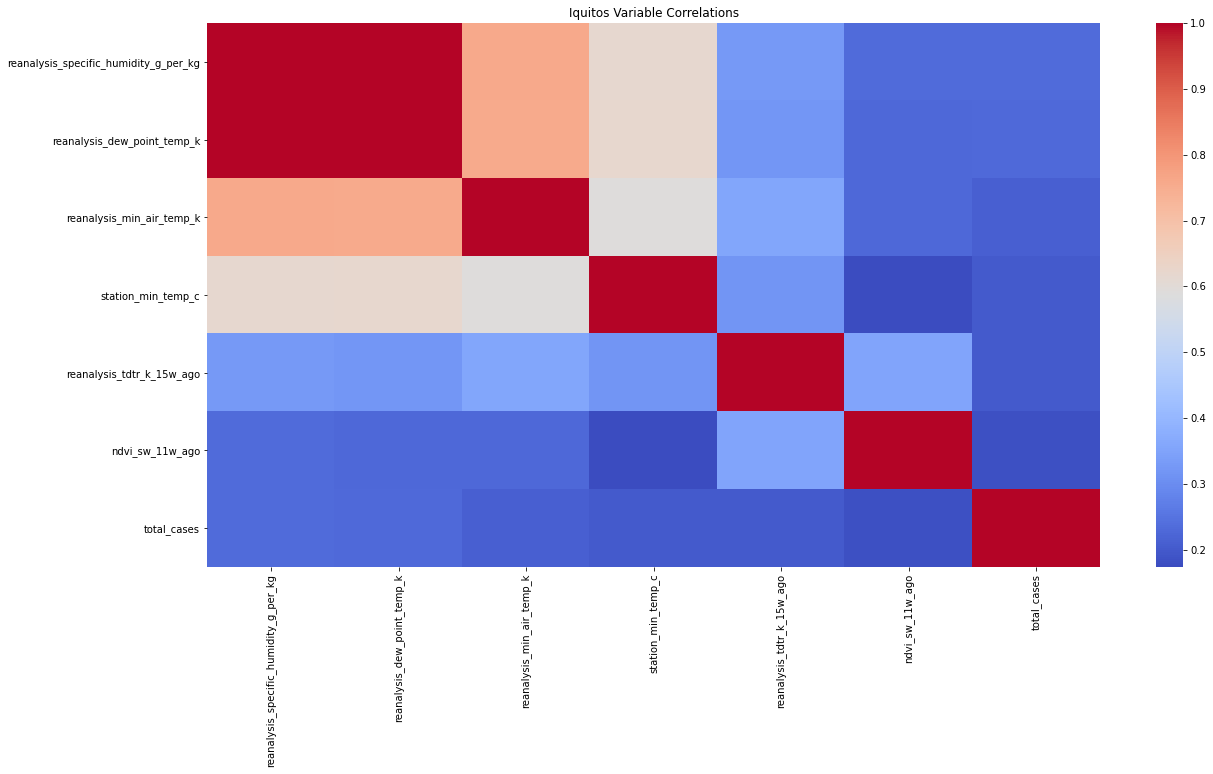

In [ ]:
# plot iquitos
iq_corr_heat = sns.heatmap(iq_correlations,cmap='coolwarm',xticklabels=True, yticklabels=True)
plt.title('Iquitos Variable Correlations')

In [ ]:
sol = (iq_correlations.where(np.triu(np.ones(iq_correlations.shape), k=1).astype(np.bool))
                 .stack()
                 .sort_values(ascending=False))
for index, value in sol.items():
  if value>0.90:
    print(index, value)

('reanalysis_specific_humidity_g_per_kg', 'reanalysis_dew_point_temp_k') 0.997771933803692


In [ ]:
# Iquitos
(iq_correlations
     .total_cases
     .drop('total_cases') # don't compare with myself
     .sort_values(ascending=False))


reanalysis_specific_humidity_g_per_kg    0.234918
reanalysis_dew_point_temp_k              0.228864
reanalysis_min_air_temp_k                0.210854
station_min_temp_c                       0.202844
reanalysis_tdtr_k_15w_ago                0.201115
ndvi_sw_11w_ago                          0.183551
Name: total_cases, dtype: float64

### Negative binomial regression

In [ ]:
sj_train, iq_train = preprocess_data(train_features_url, labels_path=train_labels_url)

In [ ]:
sj_train_neg_binomial = sj_train.copy()
iq_train_neg_binomial = iq_train.copy()

In [ ]:
sj_train_subtrain = sj_train_neg_binomial.head(800)
sj_train_subtest = sj_train_neg_binomial.tail(sj_train_neg_binomial.shape[0] - 800)

iq_train_subtrain = iq_train_neg_binomial.head(400)
iq_train_subtest = iq_train_neg_binomial.tail(iq_train_neg_binomial.shape[0] - 400)

In [ ]:
from statsmodels.tools import eval_measures
import statsmodels.formula.api as smf

def get_best_model(train, test, ciudad):
    # Step 1: specify the form of the model
    if ciudad == 'sj':
      model_formula = "total_cases ~ 1 + " \
                      "reanalysis_specific_humidity_g_per_kg_6w_ago + " \
                      "station_min_temp_c_7w_ago + " \
                      "station_avg_temp_c_7w_ago + " \
                      "station_max_temp_c_6w_ago + " \
                      "reanalysis_dew_point_temp_k + " \
                      "reanalysis_specific_humidity_g_per_kg"
    elif ciudad == 'iq':
      model_formula = "total_cases ~ 1 + " \
                "reanalysis_specific_humidity_g_per_kg + " \
                "reanalysis_dew_point_temp_k + " \
                "reanalysis_min_air_temp_k + " \
                "reanalysis_tdtr_k_15w_ago + " \
                "ndvi_sw_11w_ago + " \
                "station_min_temp_c"

    grid = 10 ** np.arange(-8, -3, dtype=np.float64)
                    
    best_alpha = []
    best_score = 1000
        
    # Step 2: Find the best hyper parameter, alpha
    for alpha in grid:
        model = smf.glm(formula=model_formula,
                        data=train,
                        family=sm.families.NegativeBinomial(alpha=alpha))

        results = model.fit()
        predictions = results.predict(test).astype(int)
        score = eval_measures.meanabs(predictions, test.total_cases)

        if score < best_score:
            best_alpha = alpha
            best_score = score

    print('best alpha = ', best_alpha)
    print('best score = ', best_score)
            
    # Step 3: refit on entire dataset
    full_dataset = pd.concat([train, test])
    model = smf.glm(formula=model_formula,
                    data=full_dataset,
                    family=sm.families.NegativeBinomial(alpha=best_alpha))

    fitted_model = model.fit()
    return fitted_model
    

In [ ]:
sj_best_model = get_best_model(sj_train_subtrain, sj_train_subtest,'sj')
iq_best_model = get_best_model(iq_train_subtrain, iq_train_subtest,'iq')

best alpha =  0.0001
best score =  22.308823529411764
best alpha =  1e-08
best score =  6.225


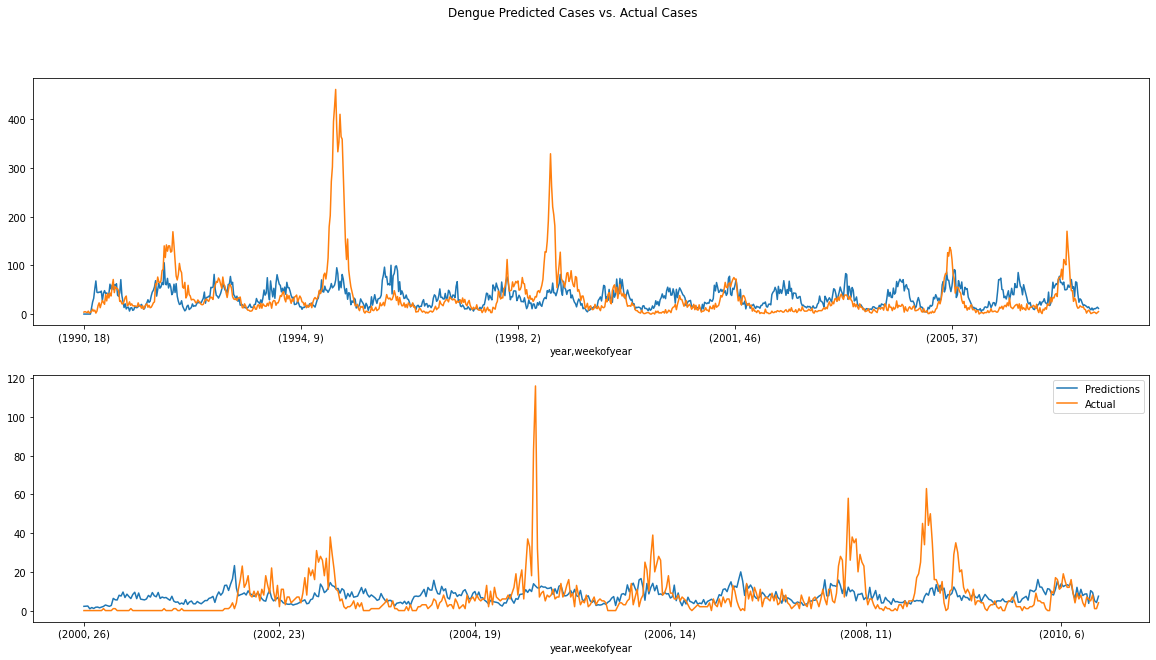

In [ ]:
figs, axes = plt.subplots(nrows=2, ncols=1)

# plot sj
sj_train_neg_binomial['fitted'] = sj_best_model.fittedvalues
sj_train_neg_binomial.fitted.plot(ax=axes[0], label="Predictions")
sj_train_neg_binomial.total_cases.plot(ax=axes[0], label="Actual")

# plot iq
iq_train_neg_binomial['fitted'] = iq_best_model.fittedvalues
iq_train_neg_binomial.fitted.plot(ax=axes[1], label="Predictions")
iq_train_neg_binomial.total_cases.plot(ax=axes[1], label="Actual")

plt.suptitle("Dengue Predicted Cases vs. Actual Cases")
plt.legend()

### KNeighbors Regressor

In [ ]:
sj_train_knn = sj_train.copy()
sj_train_knn.reset_index(drop = True, inplace = True)

iq_train_knn = iq_train.copy()
iq_train_knn.reset_index(drop = True, inplace = True)

In [ ]:
from sklearn import neighbors
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import numpy as np

cv = KFold(n_splits = 20, shuffle = False) #
#  https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html 

def knn(train_knn):
  for i, weights in enumerate(['uniform', 'distance']):
    total_scores = []
    for n_neighbors in range(1,80):
        fold_accuracy = []
        knn = neighbors.KNeighborsRegressor(n_neighbors, weights=weights, metric='euclidean')
        # verificar cada uno de los modelos con validación cruzada.
        for train_fold, test_fold in cv.split(train_knn):
            # División train test aleatoria
            f_train = train_knn.loc[train_fold]
            f_test = train_knn.loc[test_fold]
            # entrenamiento y ejecución del modelo
            knn.fit( X = f_train.drop(['total_cases'], axis=1), 
                                y = f_train['total_cases'])
            y_pred = knn.predict(X = f_test.drop(['total_cases'], axis = 1))
            # evaluación del modelo
            mae = mean_absolute_error(f_test['total_cases'], y_pred)
            fold_accuracy.append(mae)
        total_scores.append(sum(fold_accuracy)/len(fold_accuracy))
    
    plt.plot(range(1,len(total_scores)+1), total_scores, 
              marker='o', label=weights)
    print ('Min Value ' +  weights + " : " +  str(min(total_scores)) +" (" + str(np.argmin(total_scores) + 1) + ")")
    plt.ylabel('MAE')

  plt.legend()
  plt.show() 





Min Value uniform : 25.233543676490022 (63)
Min Value distance : 25.314390962698354 (63)


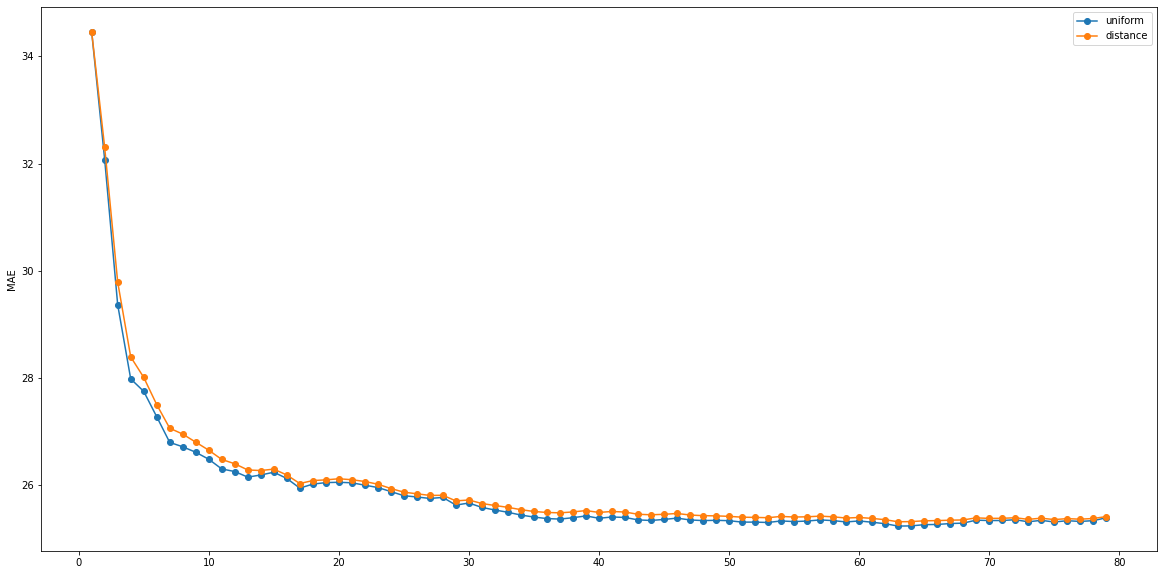

In [ ]:
knn(sj_train_knn )

Min Value uniform : 6.680048076923076 (40)
Min Value distance : 6.757668596894318 (42)


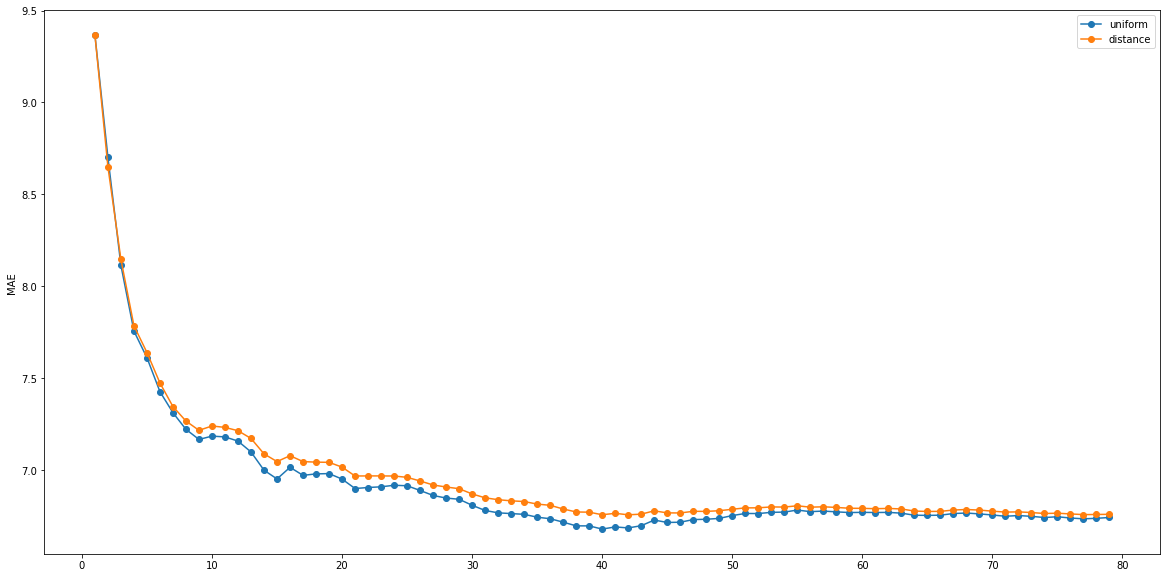

In [ ]:
knn(iq_train_knn)

In [ ]:
# constructor
n_neighbors = 63
weights = 'uniform'
knn = neighbors.KNeighborsRegressor(n_neighbors= n_neighbors, weights=weights, metric='euclidean') 
# fit and predict

knn.fit( X = sj_train_knn.drop(['total_cases'], axis=1), y = sj_train_knn['total_cases'])
y_pred_sj = knn.predict(X = sj_train_knn.drop(['total_cases'], axis = 1))

mae = mean_absolute_error(sj_train_knn['total_cases'], y_pred_sj)
print ('MAE', mae)


MAE 23.67757088590422


In [ ]:
# constructor
n_neighbors = 40
weights = 'uniform'
knn = neighbors.KNeighborsRegressor(n_neighbors= n_neighbors, weights=weights) 
# fit and predict

knn.fit( X = iq_train_knn.drop(['total_cases'], axis=1), y = iq_train_knn['total_cases'])
y_pred_iq = knn.predict(X = iq_train_knn.drop(['total_cases'], axis = 1))

mae = mean_absolute_error(iq_train_knn['total_cases'], y_pred_iq)
print ('MAE', mae)

MAE 6.241346153846154


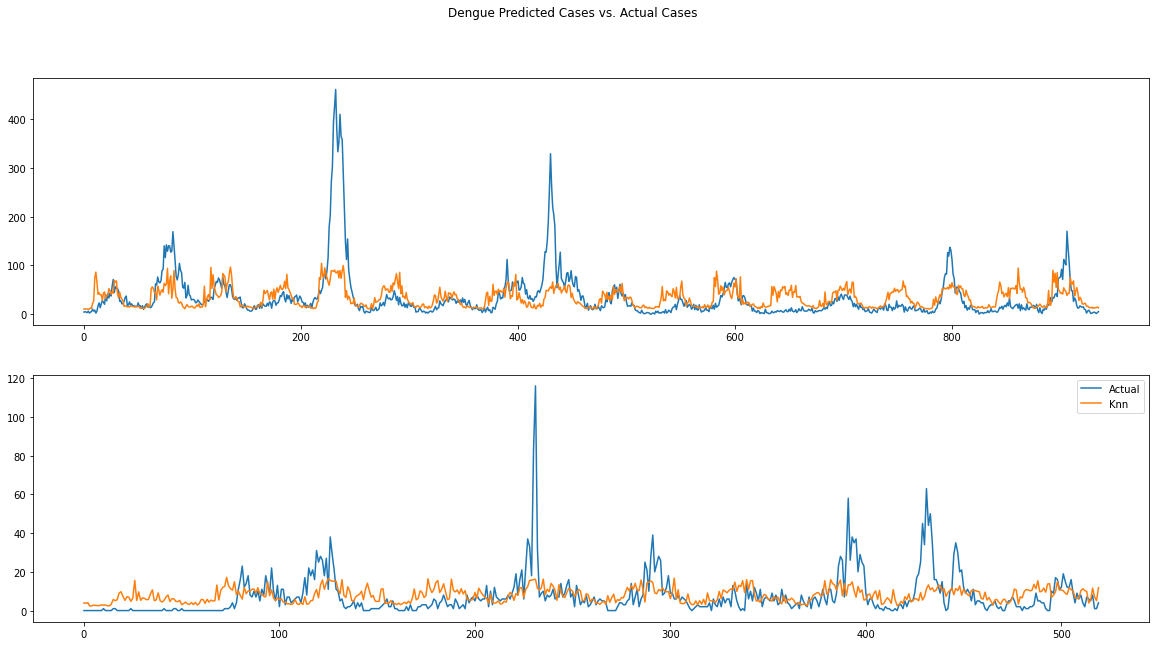

In [ ]:
figs, axes = plt.subplots(nrows=2, ncols=1)

# plot sj

sj_train_knn.total_cases.plot(ax=axes[0], label="Actual")
axes[0].plot(y_pred_sj, label="Knn")

# plot iq
iq_train_knn.total_cases.plot(ax=axes[1], label="Actual")
axes[1].plot(y_pred_iq, label="Knn")

plt.suptitle("Dengue Predicted Cases vs. Actual Cases")
plt.legend()

In [ ]:
sj_test, iq_test = preprocess_data(test_features_url)

#ensemble (mean)

"""
sj_predictions = ((knn.predict(sj_test) + sj_best_model.predict(sj_test))/2).astype(int)
iq_predictions = ((knn.predict(iq_test) + iq_best_model.predict(iq_test))/2).astype(int)
"""

#full knn regressor
"""
sj_predictions = knn.predict(sj_test).astype(int)
iq_predictions = knn.predict(iq_test).astype(int)
"""
#full negative regressor

sj_predictions = sj_best_model.predict(sj_test).astype(int)
iq_predictions = iq_best_model.predict(iq_test).astype(int)



submission.total_cases = np.concatenate([sj_predictions, iq_predictions])

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

submission.to_csv("benchmark.csv")

Mounted at /content/gdrive
